# Fountain Droplet Model

Observation: smaller droplets fly further from the source of a vertically oriented fountain than large droplets when exposed to wind.

Objective: visualise how the mass of a water droplet launched vertically from a fountain relates to the horizontal distance travelled by the droplet when blown by the wind. 

Assumptions: 
1. Droplet size and shape are constant during flight
2. Droplets are oblate spheroids with minimised drag coefficients in both vertical and horizontal directions (rather than along norm)
3. No collisions occur between droplets (droplets are modelled iteratively)
4. Droplet sizes and velocities are normally distributed

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math


In [121]:
class Droplet:
    def __init__(self, diameter, vert_vel, lat_vel, wind_vel):
        self.diam = diameter
        self.vert_vel = vert_vel
        self.lat_vel = lat_vel
        self.wind_vel = wind_vel
        self.mass = (math.pi/6)*math.pow(self.diam, 3)*1000000  # assume density of 1000 kg/m^3
        self.ca = math.pi*self.diam  # assume diam is for max width of oblate spheroid and shape is constant
        self.vel = [self.lat_vel, self.vert_vel]
        self.height = 0.000
        self.range = 0.0  # horizontal distance from origin
        self.position = [self.range, self.height]
        self.flight_time = 0.000
        self.traj = pd.DataFrame(columns=['time', 'x', 'y', 'lat_vel', 'vert_vel'])

    def get_vert_drag(self):
        rho = 1.204  # density of air in kg/m^3
        cd = 0.06  # drag coef of assumed oblate spheroid
        force = 0.5 * rho * math.pow(self.vel[1], 2) * cd * self.ca  # drag equation
        if self.vel[1] > 0:
            return -force
        else:
            return force  # guarantees drag is a deceleration force regardless of sign of velocity

    def get_lat_drag(self):
        rho = 1.204  # density of air in kg/m^3
        cd = 0.06  # drag coeff of assumed sphere
        rel_vel = self.wind_vel - self.vel[0]  # 'wind speed'
        force = 0.5 * rho * math.pow(rel_vel, 2) * cd * self.ca  # drag equation
        return force

    def get_vert_accel(self):
        g = -9.81  # gravitational acceleration
        grav_force = g*self.mass
        vert_drag = self.get_vert_drag()
        vert_accel = (grav_force + vert_drag)/self.mass
        return vert_accel

    def get_lat_accel(self):
        lat_drag = self.get_lat_drag()
        drag_accel = lat_drag/self.mass
        return drag_accel

    def accelerate(self, time: float):
        self.vel[1] += self.get_vert_accel()*time
        self.vel[0] += self.get_lat_accel()*time

    def update_position(self, time: float):
        self.position[1] += self.vel[1]*time
        self.position[0] += self.vel[0]*time

    def fly(self, step):
        self.update_position(step)
        while self.position[1] > 0:
            self.accelerate(step)
            self.update_position(step)
            self.flight_time += step
            values = [self.flight_time, self.position[0], self.position[1], self.vel[0], self.vel[1]]
            new_df = pd.DataFrame([values], columns=['time', 'x', 'y', 'lat_vel', 'vert_vel'])
            self.traj = pd.concat([self.traj, new_df])

    def plot_traj(self):
        self.traj.plot(x='x', y='y', kind='scatter', use_index=True, xlabel='distance', ylabel='height')
        plt.show()
        

In [122]:
drops_list = []

def make_drops(number, mean_diam, mean_vel, diam_sd, vel_sd, wind_speed):
    for i in range(number):
        diam = np.random.normal(mean_diam, diam_sd, size=None)
        if diam <= 0:
            diam = mean_diam
        vert_vel = np.random.normal(mean_vel, vel_sd, size=None)
        i = Droplet(diam, vert_vel, 0, wind_speed)
        drops_list.append(i)


def fly_all_drops(step):
    for i in drops_list:
        i.fly(step)


In [123]:
number_of_drops = 1000
mean_diameter = 0.002
diameter_sd = 0.0002
mean_velocity = 10
velocity_sd = 0.1
wind_speed = 4
time_step = 0.01


make_drops(number_of_drops, mean_diameter, mean_velocity, diameter_sd, velocity_sd, wind_speed)
fly_all_drops(time_step)


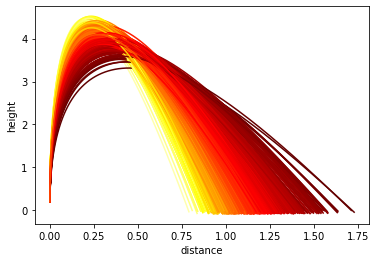

In [124]:
from matplotlib import cm

def plot_all_traj():
    for i in drops_list:
        plt.plot(i.traj['x'], i.traj['y'], c=cm.hot(i.mass*100))
    plt.xlabel('distance (m)')
    plt.ylabel('height (m)')
    plt.show()

plot_all_traj()


NB: 'hotter' traces are more massive droplets. 

Generally, more massive droplets achieve higher vertical maximum heights and smaller horizontal displacements from the origin than do smaller droplets.

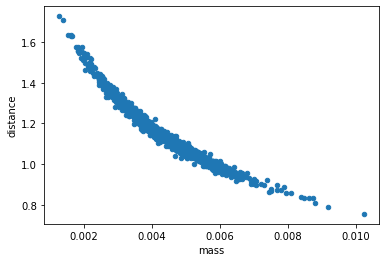

In [125]:
def plot_drops():
    data = {'distance': [], 'flight_time': [], 'mass': []}
    for i in drops_list:
        data['distance'].append(i.position[0])
        data['flight_time'].append(i.flight_time)
        data['mass'].append(i.mass)
    results = pd.DataFrame.from_dict(data)
    results.plot(x='mass', y='distance', kind='scatter', use_index=True)
    plt.show()

plot_drops()


The horizontal displacement is inversely correlated to droplet mass

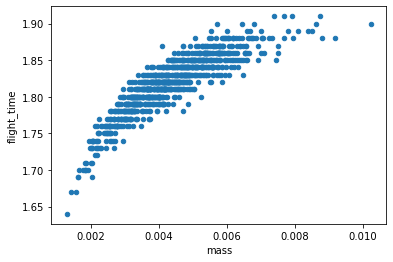

In [130]:
def plot_flight_times():
    data = {'distance': [], 'flight_time': [], 'mass': []}
    for i in drops_list:
        data['distance'].append(i.position[0])
        data['flight_time'].append(i.flight_time)
        data['mass'].append(i.mass)
    results = pd.DataFrame.from_dict(data)
    results.plot(x='mass', y='flight_time', kind='scatter', use_index=True)
    plt.show()

plot_flight_times()


The flight time of a droplet is positively correlated to its mass. Note striations due to discrete time step

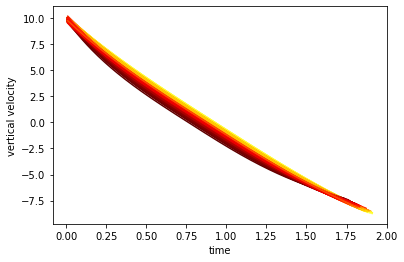

In [126]:
def plot_vert_vels():
    for i in drops_list:
        plt.plot(i.traj['time'], i.traj['vert_vel'], c=cm.hot(i.mass*100))
    plt.xlabel('time (s)')
    plt.ylabel('vertical velocity (m/s)')
    plt.show()

plot_vert_vels()


Lighter droplets appear to follow more parabolic velocity curves as the decelleration effect of drag is a greater proportion of the total force for small droplets than large ones. Thus, vertical decelleration of the droplet is larger while velocity is positive while its vertical acceleration is smaller when its velocity is negative. Conversely, the vertical acceleration of larger droplets is dominated by gravity, thus the velocity curves are more linear. 

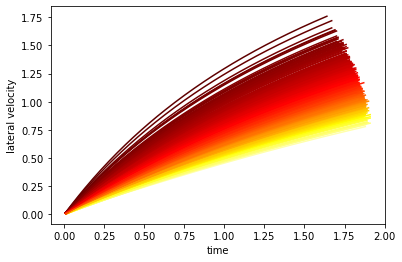

In [127]:
def plot_lat_vels():
    for i in drops_list:
        plt.plot(i.traj['time'], i.traj['lat_vel'], c=cm.hot(i.mass*100))
    plt.xlabel('time (s)')
    plt.ylabel('lateral velocity (m/s)')
    plt.show()
    
plot_lat_vels()

The lateral acceleration of lighter droplets is larger than for heavier droplets. This is expected as cross-sectional area, and therefore the force of the wind, increases as the square of diameter while volume (and therefore mass and inertia) increases by the cube, resulting in lower accelerations. 